In [1]:
import os
import time
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="*", force=True))
import pickle
import gzip
import copy
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import torchvision
# from curriculum_deeplab.data_parameters import DataParamMode
import torchio as tio

import matplotlib.pyplot as plt
from IPython.display import display
import nibabel as nib
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d, dice2d
from mdl_seg_class.visualization import visualize_seg
from curriculum_deeplab.mindssc import mindssc

from pathlib import Path

import wandb
import random
import glob
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

print(torch.__version__)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  ---------
   0  Tesla T4                       0 %   14910 MiB  11.6(510.39.01)
   1  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.6(510.39.01)
   3  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.6(510.39.01)
   4  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.6(510.39.01)
   5  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.6(510.39.01)
   2  Quadro RTX 8000             ! 97 %   19202 MiB  11.6(510.39.01)  weihsbach

Will apply following mapping

  ID  Card name        torch
----  -----------  --  -------
   0  Tesla T4     ->  cuda:0
1.9.0a0+gitdfbd030
8302
Tesla T4


In [2]:
def in_notebook():
    try:
        get_ipython().__class__.__name__
        return True
    except NameError:
        return False

if in_notebook:
    THIS_SCRIPT_DIR = os.path.abspath('')
else:
    THIS_SCRIPT_DIR = os.path.dirname(os.path.realpath(__file__))
print(f"Running in: {THIS_SCRIPT_DIR}")

Running in: /share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab


dashing-surf-1206_fold0_epx39/train_label_snapshot.pth has 400 parameters.
gt_sum 0.17672321872724686
dice 0.6513733614032037
pp_sum 0.01632665924998889
sqrt_gt_sum 0.2450138798766624
log_gt_sum 0.2762505082950342
e_log_gt_sum 0.2814289391965071
inv_e_log_gt_sum -0.18855239587471898
Corr coeff DP_weight/dice 0.65 vs. DP_reweight/dice with gt_sum 0.13
Corr coeff DP_weight/dice 0.65 vs. DP_reweight/dice with pp_sum 0.58
Corr coeff DP_weight/dice 0.65 vs. DP_reweight/dice with sqrt_gt_sum 0.13
Corr coeff DP_weight/dice 0.65 vs. DP_reweight/dice with log_gt_sum 0.51
Corr coeff DP_weight/dice 0.65 vs. DP_reweight/dice with e_log_gt_sum 0.66
Corr coeff DP_weight/dice 0.65 vs. DP_reweight/dice with inv_e_log_gt_sum 0.63


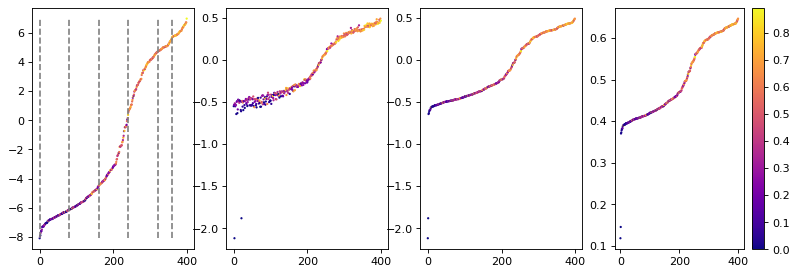

In [3]:
file_paths = [
    # '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/crimson-oath-956_fold0_epx39/train_label_snapshot.pth',
    # '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/_clean-morning-918_fold0_epx39/train_label_snapshot.pth'
    '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/dashing-surf-1206_fold0_epx39/train_label_snapshot.pth'
]

# file_paths = glob.glob('./data/output/**/*.pth')

for _path in file_paths:
    data = torch.load(_path)
    if not 'disturb_flags' in data: continue
    dp_mean_weight = data['data_parameters'].squeeze().detach().cpu()
    disturb_flags = data['disturb_flags'] 
    d_ids = data['d_ids'] 
    dataset_idxs = data['dataset_idxs'] 
    _3d_labels = data['labels']
    _3d_modified_labels = data['modified_labels']
    _3d_predictions = data['train_predictions']
    print(f"{'/'.join(_path.split('/')[-2:])} has {len(dp_mean_weight)} parameters.")

    _3d_labels = _3d_labels.to_dense()
    _3d_modified_labels = _3d_modified_labels.to_dense()
    _3d_predictions = _3d_predictions.to_dense()

    gt_sum = _3d_modified_labels.sum((-3,-2,-1))
    pp_sum = _3d_predictions.sum((-3,-2,-1)).squeeze(1).cpu()
    rgt_sum =  _3d_labels.sum((-3,-2,-1)).cpu()
    intersect = torch.logical_and(_3d_labels, _3d_modified_labels).sum((-3,-2,-1))
    dice = 2*intersect/(rgt_sum+gt_sum+1)

    all_elems = \
        dict(
            # disturbed_bool_vect = torch.tensor(disturb_flags).float(),
            gt_sum=gt_sum, 
            dice=dice, 
            pp_sum=pp_sum,
            sqrt_gt_sum=np.sqrt(gt_sum),
            log_gt_sum=np.log(gt_sum+1)+1, # this seems to be right
            e_log_gt_sum=np.log(gt_sum+np.exp(1))+np.exp(1),
            inv_e_log_gt_sum=1/(np.log(gt_sum+np.exp(1))+np.exp(1)),
        )
    
    for name, metric in all_elems.items():
        print(name, np.corrcoef(dp_mean_weight.cpu().detach(), metric.detach())[0,1])
    for name, metric in all_elems.items():
        if name in ['dice', 'disturbed_bool_vect']: continue
        
        print(f"Corr coeff DP_weight/dice {np.corrcoef(dp_mean_weight.detach(), dice.detach())[0,1]:.2f} vs. DP_reweight/dice with {name} {np.corrcoef((dp_mean_weight/(metric+1e-6)).cpu().detach(), dice.detach())[0,1]:.2f}")
    reweighted = dp_mean_weight/(all_elems['e_log_gt_sum'])

    # sel_idxs = reweighted<100
    sel_idxs = range(len(reweighted))
    srtd_reweighted = reweighted[sel_idxs]
    srtd_dice_reweighted = dice[sel_idxs]

    srtd = sorted(zip(srtd_reweighted, srtd_dice_reweighted))
    srtd_reweighted, srtd_dice_reweighted = zip(*srtd)
    srtd_reweighted, srtd_dice_reweighted = torch.stack(srtd_reweighted), torch.stack(srtd_dice_reweighted)

    # Show weights and weights with compensation
    fig, axs = plt.subplots(1,4, figsize=(12, 4), dpi=80)
    sc1 = axs[0].scatter(
        range(len(dp_mean_weight)), 
        dp_mean_weight.cpu().detach(), c=dice,s=1, cmap='plasma');
    sc2 = axs[1].scatter(
        range(len(dp_mean_weight)), 
        reweighted.cpu().detach(), 
        s=1,c=dice, cmap='plasma')
    sc3 = axs[2].scatter(
        range(len(srtd_reweighted)), 
        srtd_reweighted.detach().numpy(), 
        s=1,c=srtd_dice_reweighted, cmap='plasma');
    sc4 = axs[3].scatter(
        range(len(srtd_reweighted)), 
        torch.sigmoid(srtd_reweighted-srtd_reweighted.mean()).detach().numpy(), 
        s=1,c=srtd_dice_reweighted, cmap='plasma');
    plt.colorbar(sc4)
    axs[0].vlines(len(dp_mean_weight)*.0, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    axs[0].vlines(len(dp_mean_weight)*.2, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    axs[0].vlines(len(dp_mean_weight)*.4, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    axs[0].vlines(len(dp_mean_weight)*.6, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    axs[0].vlines(len(dp_mean_weight)*.8, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    axs[0].vlines(len(dp_mean_weight)*.9, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    plt.show()

In [ ]:
print(gt_sum[-20:])

print(dp_mean_weight[-20:])
dp_mean_weight[-20:]/(1+np.exp(1))
# (np.log(gt_sum+np.exp(1))+np.exp(1))

print(len(dp_mean_weight))
print(len(gt_sum))

print(reweighted[-20:])


In [8]:
def interpolate_sample(b_image=None, b_label=None, scale_factor=1.,
                       yield_2d=False):
    if yield_2d:
        scale = [scale_factor]*2
        im_mode = 'bilinear'
    else:
        scale = [scale_factor]*3
        im_mode = 'trilinear'

    if b_image is not None:
        b_image = F.interpolate(
            b_image.unsqueeze(1), scale_factor=scale, mode=im_mode, align_corners=True,
            recompute_scale_factor=False
        )
        b_image = b_image.squeeze(1)

    if b_label is not None:
        b_label = F.interpolate(
            b_label.unsqueeze(1).float(), scale_factor=scale, mode='nearest',
            recompute_scale_factor=False
        ).long()
        b_label = b_label.squeeze(1)

    return b_image, b_label

datas = zip(dp_mean_weight, d_ids, _3d_labels, _3d_modified_labels, _3d_predictions)


samples_sorted = sorted(datas, key=lambda tpl: tpl[0])[-20:]
(dp_weightss, d_idss, _3d_lbl, _3d_ml, _3d_p) = zip(*samples_sorted)
print(dp_weightss)
overlay_text_list = [f"id:{d_id} DP:{instance_p.item():.2f}" \
    for d_id, instance_p in zip(d_idss, dp_weightss)]

visualize_seg(in_type="batch_3D", reduce_dim="W",
    img=interpolate_sample(b_label=torch.stack(_3d_lbl), scale_factor=.5, yield_2d=False)[1].unsqueeze(1),
    seg=interpolate_sample(b_label=4*torch.stack(_3d_p).squeeze(), scale_factor=.5, yield_2d=False)[1],
    ground_truth=interpolate_sample(b_label=torch.stack(_3d_ml), scale_factor=.5, yield_2d=False)[1],
    alpha_seg = .5,
    alpha_gt = .5,
    n_per_row=50,
    overlay_text=overlay_text_list,
    annotate_color=(0,255,255),
    file_path="out_best_3d.png",
)

(tensor(6.0648), tensor(6.0861), tensor(6.1029), tensor(6.1061), tensor(6.1214), tensor(6.1341), tensor(6.2278), tensor(6.2925), tensor(6.3231), tensor(6.3766), tensor(6.3825), tensor(6.4732), tensor(6.4900), tensor(6.5221), tensor(6.5386), tensor(6.5863), tensor(6.6024), tensor(6.6925), tensor(6.6972), tensor(6.9580))


In [ ]:
torch.save(
    {
        'reweighted_weigths': sg_reweighted,
        'd_ids': d_ids 
    }, 
    'fixed_weights.pth'
)


In [ ]:
correction = \
    [
        1.0,
        1/(1+gt_sum).numpy(), 
        1/(1+np.sqrt(gt_sum)).numpy(),
        1/np.log(gt_sum+gt_sum.max().sqrt()).numpy(),
    ]

for crr in correction:
    print(np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy()*crr, dice)[0,1])


In [ ]:
import glob
import pandas as pd
corrs = {}
def get_corr_coeff(inp):
    return np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy(), inp)[0,1]

for pth in glob.glob('./data/output/**/*.pth'):
    print(pth)
    data = torch.load(pth)
    dp_mean_weight, *_, d_ids, dataset_idxs, _2d_labels, _2d_modified_labels = data
    gt_sum = _2d_modified_labels.sum((-2,-1))
    pp_sum = _2d_labels.sum((-2,-1))
    intersect = torch.logical_and(_2d_labels, _2d_modified_labels).sum((-2,-1))
    dice = 2*intersect/(pp_sum+gt_sum)
    all_elems = dict(
            gt_sum=get_corr_coeff(gt_sum),
            intersect=get_corr_coeff(intersect),
            pp_sum=get_corr_coeff(pp_sum),
            sqrt=get_corr_coeff(np.sqrt(gt_sum)),
            log=get_corr_coeff(np.log(gt_sum+gt_sum.max().sqrt())), # this seems to be right
            dice=get_corr_coeff(dice)
    )
    corrs[pth.split('/')[-2]] = all_elems
    # break
df = pd.DataFrame(corrs)
df.to_csv('pd.csv')
print(df)
